# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame input | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,356] | 0.1|
 


<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |
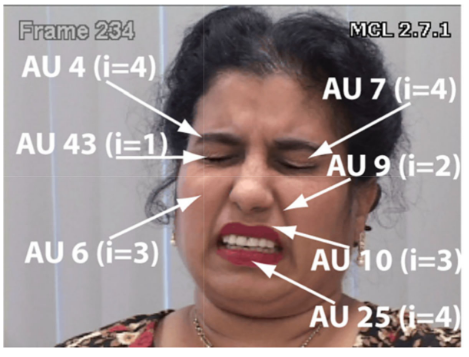

STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

# COde

In [3]:
with open("k710_labels/k710_label_map.txt",'r') as f:
  label_map = f.readlines()
  label_map = [x.strip() for x in label_map]
  print(len(label_map))
  print(label_map)
label_map = np.array(label_map)

FileNotFoundError: [Errno 2] No such file or directory: 'k710_labels/k710_label_map.txt'

In [ ]:
label_prediction_dict = {}
np_labels = np.array(list_labels)
class_results = np.array(list_results)
for label in np.unique(np_labels):
  # print(f"Label: {label}, Prediction: {prediction}")
  mask = (np_labels == label)
  masked_results  = class_results[mask]
  label_prediction_dict[label] = masked_results
prediction_to_label = {k:(list(zip(label_map[np.unique(v)],np.unique(v,return_counts=True)[1]))) for k,v in label_prediction_dict.items()}
for k,v in prediction_to_label.items():
  print(f'{k}: {v}')
accuracy_dict = {}
for label in label_prediction_dict:
  count_prediction = np.bincount(label_prediction_dict[label])
  accuracy_dict[label] = count_prediction.max().item() / count_prediction.sum().item()
print('\nAccuracy dict:')
for k,v in accuracy_dict.items():
  print(f'  {k}: {v}')
print('Mean accuracy:', np.mean(list(accuracy_dict.values())))


bend: [('fixing hair', 4), ('pushing cart', 1), ('tying necktie', 3), ('standing on hands', 1)]
jack: [('jumping jacks', 9)]
jump: [('sword fighting', 1), ('tiptoeing', 8)]
pjump: [('cooking chicken', 6), ('disc golfing', 1), ('tiptoeing', 1), ('jumping jacks', 1)]
robust_view: [('fixing hair', 2), ('ripping paper', 1), ('weaving basket', 7)]
side: [('weaving basket', 1), ('tiptoeing', 7), ('acting in play', 1)]
skip: [('playing harmonica', 9), ('tiptoeing', 1)]
walk: [('texting', 1), ('weaving basket', 3), ('tiptoeing', 3), ('moon walking', 3)]
wave1: [('fixing hair', 1), ('pushing car', 5), ('riding unicycle', 3)]
wave2: [('fixing hair', 1), ('pushing car', 8)]

Accuracy dict:
  bend: 0.4444444444444444
  jack: 1.0
  jump: 0.8888888888888888
  pjump: 0.6666666666666666
  robust_view: 0.7
  side: 0.7777777777777778
  skip: 0.9
  walk: 0.3
  wave1: 0.5555555555555556
  wave2: 0.8888888888888888
Mean accuracy: 0.7122222222222222


In [ ]:
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import custom.tools as tools

feature_frontalized_path = "partA/video/features/samples_16_frontalized"
feature_frontalized = tools.load_dict_data(feature_frontalized_path)
feature_frontalized_new_path = "partA/video/features/samples_16_frontalized_new"
feature_frontalized_new = tools.load_dict_data(feature_frontalized_new_path)


/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
list_unique_sample_id = np.unique(feature_frontalized['list_sample_id'])
list_cosine_similarity = []
for sample_id in list_unique_sample_id:
  mask = feature_frontalized['list_sample_id'] == sample_id
  mask_new = feature_frontalized_new['list_sample_id'] == sample_id
  feature_old = feature_frontalized['features'][mask].reshape(feature_frontalized['features'][mask].shape[0],-1)
  feature_new = feature_frontalized_new['features'][mask_new].reshape(feature_frontalized_new['features'][mask_new].shape[0],-1)
  cosine_sim = cosine_similarity(feature_old,feature_new)
  list_cosine_similarity.append(cosine_sim.min())
  # print(f"Sample id: {sample_id}, cosine similarity: {cosine_sim.mean()}")
list_cosine_similarity = np.array(list_cosine_similarity)

7092485
Activation shape: torch.Size([8, 1, 768])


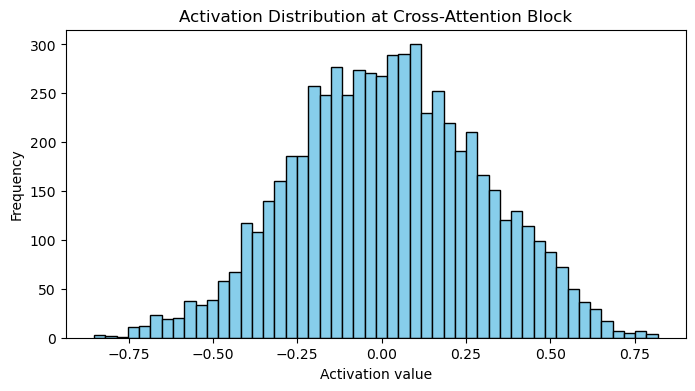

In [ ]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('jepa')
from jepa.src.models.attentive_pooler import AttentiveClassifier
att_classifier = AttentiveClassifier(num_classes=5,pos_enc=True)
num_params = sum(p.numel() for p in att_classifier.parameters())
print(num_params)
x_sample = torch.randn(2,3,768)
att_classifier(x_sample)
x_sample = torch.randn(2,5,768)
att_classifier(x_sample)

# Dictionary to store activations from the hook.
activations = {}

def activation_hook(module, input, output):
    # Save the output (detach to avoid keeping the computation graph)
    activations['attn_out'] = output.detach()

# Register the forward hook on the cross_attention_block.
# If you want to monitor the final output of the cross-attention block, register it on that module.
hook_handle = att_classifier.pooler.cross_attention_block.register_forward_hook(activation_hook)

# Run a forward pass with your input (make sure your input x is of shape [B, T, C]).
dummy_input = torch.randn(8, 196, 768)  # Example: batch size 8, sequence length 196, embedding size 768.
_ = att_classifier(dummy_input)

# Now extract the activations.
attn_activations = activations.get('attn_out')
if attn_activations is None:
    print("No activations captured. Check your hook registration.")
else:
    print("Activation shape:", attn_activations.shape)
    # Flatten and convert to CPU numpy array for plotting.
    act_flat = attn_activations.view(-1).cpu().numpy()
    plt.figure(figsize=(8, 4))
    plt.hist(act_flat, bins=50, color='skyblue', edgecolor='black')
    plt.title("Activation Distribution at Cross-Attention Block")
    plt.xlabel("Activation value")
    plt.ylabel("Frequency")
    plt.show()

# Remove the hook to avoid unwanted effects in further passes.
hook_handle.remove()


In [ ]:
import custom.head as head
attentive_head = head.AttentiveClassifierJEPA(num_classes=5,num_heads=8,embed_dim=768,
                                              mlp_ratio=1,depth=3,
                                              cross_block_after_transformers=False)
# count params in attentive head
num_params = sum(p.numel() for p in attentive_head.parameters())
print(num_params)
name_params = [name for name, param in attentive_head.named_parameters()]

/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:462: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/ho

10644485


In [ ]:
gpu_for_num_params = num_params * 4 / (1024**3)  # Convert to GB
print(f"Number of parameters in GB: {gpu_for_num_params:.2f} GB")

Number of parameters in GB: 2.84 GB


In [ ]:
l1_norm = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad and not 'bias' in name_params)
l1_norm_tot = sum(param.abs().sum() for param in attentive_head.parameters() if param.requires_grad)

tensor(336772.0938, grad_fn=<AddBackward0>)
tensor(336772.0938, grad_fn=<AddBackward0>)


In [ ]:
import pandas as pd

csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
filter_ = {
  'class_id':[0,3]
}
new_df = df[df['class_id'].isin(filter_['class_id'])]
# set class id 4 to 1
new_df['class_id'] = new_df['class_id'].replace(filter_['class_id'][1],1)
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_{filter_['class_id'][0]}_{filter_['class_id'][1]}.csv",index=False,sep='\t')

/tmp/ipykernel_313129/1632475640.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['class_id'] = new_df['class_id'].replace(filter_['class_id'][1],1)


In [ ]:
import custom.tools as tools
dict_data = tools.load_dict_data("/media/villi/TOSHIBA EXT/samples_16_frontalized_new_giant_hflip")
dict_data['list_sample_id']

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt


tensor([ 8701,  8701,  8701,  ..., 17400, 17400, 17400], dtype=torch.int32)

In [ ]:
import pandas as pd
import custom.helper as helper
stoic = helper.stoic_subjects
csv_path = "partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(csv_path,sep='\t')
key = 'subject_id'
all_subjects = df[key].unique()
no_stoic = [s for s in all_subjects if s not in stoic]
filter_ = {
  key: no_stoic
}
new_df = df[df[key].isin(filter_[key])]
new_df.to_csv(f"partA/starting_point/samples_exc_no_detection_no_stoic.csv",index=False,sep='\t')

In [ ]:
from custom.faceExtractor import FaceExtractor
import cv2
import pickle
face_extractor = FaceExtractor(visionRunningMode='image')
image_path = "new_image/img.png"

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
dict_result = face_extractor.frontalize_img(frame=img,ref_landmarks=ref_landmarks['mean_facial_landmarks'])

landmarks: [[[ 0.53349113  0.73721206 -0.04900459]
  [ 0.56110024  0.64085484 -0.11650103]
  [ 0.53716546  0.66280329 -0.0548819 ]
  ...
  [ 0.64282316  0.44705456  0.05618581]
  [ 0.62781429  0.46424106  0.05615493]
  [ 0.64082229  0.4851304   0.05616147]]]
rigid_transform_3D: A.shape: (3, 478), B.shape: (3, 478)


W0000 00:00:1746715264.809660  870552 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1746715264.866672  870552 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


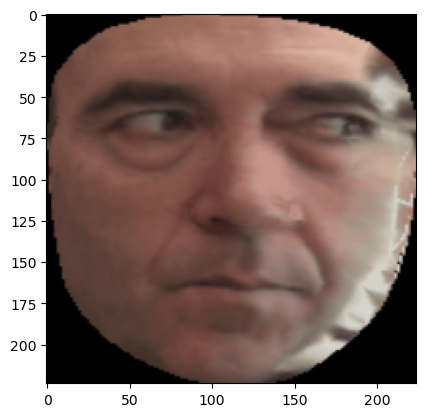

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dict_result['frontalized_img'])
# dict_result['frontalized_img']

In [ ]:
import pickle
pkl_path="history_run_1_96404_ATTENTIVE_JEPA_villi-Inspiron-16-Plus-7620_1743712318/1743712318371_VIDEOMAE_v2_B_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
data['results'].keys()

dict_keys(['k0_cross_val_sub_0'])

In [ ]:
df_path_2 = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/pre_test_drop_posEmb/_summary/plot_run_details/summary.csv"
df_2 = pd.read_csv(df_path_2)
input_path = "/media/villi/TOSHIBA EXT/test_video/test_Apr_04/test_drop_posEmb_smooth/_summary/plot_run_details/summary.csv"
df = pd.read_csv(input_path)
concatenate_df = pd.concat([df, df_2], axis=0)
concatenate_df.to_csv("summary_concat.csv",index=False)

In [ ]:
import numpy as np
import pandas as pd

def process_summary_csv(
  df,
  output_csv_path="df_filtered.csv",
  filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0},
  fixed_col=['label_smooth'],
  hyper_cols=['ATTENTIVE_JEPA.dropout', 'ATTENTIVE_JEPA.attn_dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc'],
  metric=['total_mean_val_accuracy_best_ep'],
  additional_cols=['total_mean_test_accuracy_best_ep']
):
  """
  Processes the summary CSV file by filtering rows based on fixed parameter values,
  selecting specific columns, grouping by unique hyperparameter values, and calculating
  the difference in the specified metric between the best and worst cases for each group.

  Parameters:
    input_csv_path (str): Path to the input CSV file.
    output_csv_path (str): Path to save the output CSV file. Defaults to "df_filtered.csv".
    fixed_vals (dict): Dictionary of column names and their fixed values for filtering.
    tmp_cols (list): List of temporary column names to include.
    hyper_cols (list): List of hyperparameter column names to group by.
    metric (list): List containing the metric column name used for determining best and worst rows.
    additional_cols (list): List of additional columns to include from the CSV.

  Returns:
    pd.DataFrame: A DataFrame with the filtered, processed, and sorted results.
  """
  cols_to_show = additional_cols[:1] + hyper_cols + fixed_col + additional_cols[1:] + metric

  df_filtered = df.copy()
  for col, val in filter_vals.items():
    df_filtered = df_filtered[df_filtered[col] == val]

  df_filtered = df_filtered[cols_to_show]
  hyper_values = df_filtered[hyper_cols].values
  
  unique_hyper_configs = np.unique(hyper_values.astype(np.float64), axis=0)

  processed_rows = []
  new_columns = cols_to_show + ['diff_validation']
  for i,col in enumerate(new_columns):
    split_cols = col.split('.')
    new_columns[i] = split_cols[-1]
  for config in unique_hyper_configs:
    mask = np.all(hyper_values == config, axis=1)
    subset = df_filtered.loc[mask]

    best_row = subset.loc[subset[metric].idxmax()]
    worst_row = subset.loc[subset[metric].idxmin()]
    metric_diff = np.round(best_row[metric].values - worst_row[metric].values, 4)

    new_row = best_row.copy()
    new_row['diff_validation'] = metric_diff[0]
    processed_rows.append(new_row.values.reshape(-1))

  df_result = pd.DataFrame(processed_rows, columns=new_columns)
  df_result.sort_values(by=metric, ascending=False, inplace=True)
  df_result.to_csv(output_csv_path, index=False)

  return df_result

# Example usage
if __name__ == "__main__":
  input_csv_path="/media/villi/TOSHIBA EXT/test_video/test_Apr_18/pre_LOSO/_summary/plot_run_details/summary.csv"
  # filter_vals={'reg_lambda_L1': 0.00001, 'reg_lambda_L2': 0}
  df = pd.read_csv(input_csv_path)
  filter_vals={}
  fixed_col=['ATTENTIVE_JEPA.attn_dropout']
  hyper_cols=['label_smooth', 'ATTENTIVE_JEPA.dropout', 'ATTENTIVE_JEPA.residual_dropout','ATTENTIVE_JEPA.pos_enc','reg_lambda_L1','reg_lambda_L2']
  metric=['total_mean_val_accuracy_best_ep']
  additional_cols=['total_mean_test_accuracy_best_ep']
  df_new = process_summary_csv(df=df,
                               additional_cols=additional_cols,
                              filter_vals=filter_vals,
                              fixed_col=fixed_col,
                              hyper_cols=hyper_cols,
                              metric=metric)

# df_new
  grouped = df.groupby(hyper_cols)
  grouped_dict = {group: df.copy() for group, df in grouped}

In [ ]:
import custom.tools as tools
video_path = "z_sampling_video/071309_w_21-PA4-043_inside_2_stride_32_fps_12.mp4"
grid_size = (14,14)
tools.split_video_with_chunks(
  video_path=video_path,
  chunk_size=16,
  new_fps=8,
  output_folder="z_debug_grid",
  separator_duration=8 
)

Video saved at z_debug_grid/071309_w_21-PA4-043_inside_2_stride_32_fps_12_chunks.mp4


In [ ]:
import custom.dataset as dataset
import custom.helper as helper

stride_inside_window = 2
clip_length = 16
color_jitter = False
flip_horizontal = False
rotation = False
ds = dataset.customDataset(
  path_dataset="partA/video/video_frontalized_new",
  path_labels="partA/starting_point/samples_exc_no_detection.csv",
  sample_frame_strategy=helper.SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW,
  clip_length=clip_length,
  stride_inside_window=stride_inside_window,
  stride_window=(clip_length)*stride_inside_window,
  saving_folder_path_extracted_video="z_sampling_video",
  color_jitter=color_jitter,
  flip_horizontal=flip_horizontal,
  rotation=rotation,
)
augm = 'hflip' if flip_horizontal else ''+ 'jitter' if color_jitter else '' + 'rotation' if rotation else ''
ds.generate_video(idx=91,fps_out=12,output_folder=f"z_debug_video_{augm}")


Set path_labels: partA/starting_point/samples_exc_no_detection.csv
Video saved to z_debug_video_jitter/071309_w_21-PA4-043_inside_2_stride_32_fps_12.mp4


{'color_jitter': {'brightness': (0.7, 1.3),
  'contrast': (0.7, 1.3),
  'saturation': (0.7, 1.3),
  'hue': (-0.05, 0.05)}}

In [ ]:
print(f'Size: {(4*8*14*14*768)*2*8700/1024**3} GB')

Size: 78.057861328125 GB


In [ ]:
import safetensors
import safetensors.torch
import torch
import custom.tools as tools

tools.convert_dict_to_safetensors(dict_folder_path="partA/video/features/samples_16_frontalized_new_rotate")

Loading files: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Converted dict saved to partA/video/features/samples_16_frontalized_new_rotate.safetensors


In [ ]:
tools.convert_dict_to_safetensors(dict_folder_path="partA/video/features/samples_16_frontalized_new")

Loading files: 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt
Error converting list_path to tensor. Not saved in the new dict
Converted dict saved to partA/video/features/samples_16_frontalized_new.safetensors


In [ ]:
import safetensors.torch
import torch
import custom.helper as helper
import custom.tools as tools
list_path = [
             "partA/video/features/samples_16_frontalized_new.safetensors",
             "partA/video/features/samples_16_frontalized_new_hflip.safetensors",
             "partA/video/features/samples_16_frontalized_new_rotation.safetensors",
             ]
for path in list_path:
  dict_data = tools.load_dict_data(path)
  print(path)
  if 'list_sample_id' in dict_data:
    # dict_data['list_sample_id'] = dict_data['list_sample_id'] + helper.get_shift_for_sample_id(path)
    print(f"  {torch.max(dict_data['list_sample_id'])}")
    print(f"  {torch.min(dict_data['list_sample_id'])}")
  # safetensors.torch.save_file(dict_data, path)

partA/video/features/samples_16_frontalized_new.safetensors
  8700
  1
partA/video/features/samples_16_frontalized_new_hflip.safetensors
  17400
  8701
partA/video/features/samples_16_frontalized_new_rotation.safetensors
  34800
  26101


In [ ]:
import safetensors.torch
import torch
import custom.helper as helper
dict_data = safetensors.torch.load_file("partA/video/features/samples_16_frontalized_new_hflip.safetensors")
for k,v in dict_data.items():
  print(f'{k}: {v.shape}')
  print(f'dtype: {v.dtype}')
  if k == 'list_sample_id':
    dict_data[k]=dict_data[k].to(torch.int32)
    dict_data[k] = dict_data[k] + helper.get_shift_for_sample_id('hflip') 
    print(torch.min(dict_data[k]).item())
    print(torch.max(dict_data[k]).item())
safetensors.torch.save_file(dict_data,"partA/video/features/samples_16_frontalized_new_rotation.safetensors")

features: torch.Size([69336, 8, 1, 1, 768])
dtype: torch.float32
list_frames: torch.Size([69336, 16])
dtype: torch.int32
list_labels: torch.Size([69336])
dtype: torch.int32
list_sample_id: torch.Size([69336])
dtype: torch.int32
8701
17400
list_subject_id: torch.Size([69336])
dtype: torch.int32


In [ ]:
import custom.tools as tools
import time
tools.test_speed_safetensors_vs_standard(path_1="partA/video/features/samples_16_frontalized_new",
                                        path_2="partA/video/features/samples_16_frontalized_new.safetensors")

Loading files: 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


Unsupported file format: config_dict.pkl
Unsupported file format: config_dict.txt
Path1 load time: 2.3284637928009033 seconds
  list_labels: torch.Size([69336])
  features: torch.Size([69336, 8, 1, 1, 768])
  list_path: (69336,)
  list_sample_id: torch.Size([69336])
  list_frames: torch.Size([69336, 16])
  list_subject_id: torch.Size([69336])


Copying data: 100%|██████████| 5/5 [00:00<00:00, 192399.27it/s]

Path2 load time: 0.01974654197692871 seconds
  features: torch.Size([69336, 8, 1, 1, 768])
  list_frames: torch.Size([69336, 16])
  list_labels: torch.Size([69336])
  list_sample_id: torch.Size([69336])
  list_subject_id: torch.Size([69336])
Speedup (path1/path2): 117.91754705818433x


In [ ]:
import pickle
import optuna
pkl_path = "study_test"
with open(pkl_path, 'rb') as f:
  study = pickle.load(f)
study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

,number,value,params_batch_train,params_cross_block_after_transformers,params_drop_attn,params_drop_residual,params_init_network,params_label_smooth,params_lr,params_mlp_ratio,params_model_dropout,params_nr_blocks,params_num_cross_head,params_num_heads,params_opt,params_pos_enc,params_regulariz_lambda_L1,params_regulariz_lambda_L2,state
0,0,0.180447,32,True,0.0,0.0,default,0.1,0.000100,0.25,0.1,2,8,None,adamw,True,0.001,0.0001,COMPLETE
1,1,0.239793,32,True,0.0,0.0,default,0.1,0.000001,0.25,0.1,2,8,None,adamw,True,0.000,0.0001,COMPLETE
2,2,0.217857,32,True,0.0,0.0,default,0.1,0.000001,0.25,0.4,2,8,None,adamw,True,0.001,0.0001,COMPLETE


In [ ]:
import joblib
import optuna
from optuna.storages import RDBStorage

# 2. Create a new SQLite storage and study record
storage = RDBStorage(url="sqlite:///study.db")
study_id = storage.create_new_study(study_name="restored_study",directions=["MAXIMIZE"])

# 3. Replay all existing trials into the DB
for trial in study.get_trials(deepcopy=False):
    storage.create_new_trial(study_id=study_id, template_trial=trial)

# 4. (Optional) Load it back as an Optuna Study
restored = optuna.load_study(study_name="restored_study", storage=storage)


[I 2025-04-17 22:18:56,147] A new study created in RDB with name: restored_study


In [ ]:
import custom.helper as helper
import custom.dataset as dataset
from custom.dataset import customDataset
path_dataset = "partA/video/video_frontalized_new"
path_labels = "partA/starting_point/samples_exc_no_detection.csv"
sample_frame_strategy = helper.SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
clip_length = 16
h_flip = False
rotation = True
color_jitter = True
preprocess_align = False
preprocess_frontalize = False
stride_inside_window = 2
stride_window = clip_length*stride_inside_window
preprocess_crop_detection = False

custom_ds = customDataset(path_dataset=path_dataset,
              path_labels=path_labels,
              sample_frame_strategy=sample_frame_strategy,
              stride_window=stride_window,
              clip_length=clip_length,
              flip_horizontal=h_flip,
              color_jitter=color_jitter,
              rotation=rotation,
              preprocess_align=preprocess_align,
              preprocess_frontalize=preprocess_frontalize,
              stride_inside_window=stride_inside_window,
              preprocess_crop_detection=preprocess_crop_detection,
              saving_folder_path_extracted_video=None)

custom_ds.generate_video(idx=93,output_folder="z_video")

Set path_labels: partA/starting_point/samples_exc_no_detection.csv
Video saved to z_video/071309_w_21-PA4-061_inside_2_stride_32_fps_24.mp4


In [ ]:
import pandas as pd
import numpy as np  
path_csv_1 = "partA/starting_point/samples.csv"
path_csv_2 = "partA/starting_point/samples_exc_no_detection.csv"

df_1 = pd.read_csv(path_csv_1,sep='\t')
df_2 = pd.read_csv(path_csv_2,sep='\t')

list_sample_id_1 = df_1['sample_id'].to_list()
list_sample_id_2 = df_2['sample_id'].to_list()
mask_1 = df_1['sample_id'].isin(list_sample_id_2)
len_1 = len(list_sample_id_1)
len_2 = len(list_sample_id_2)
print(f"Length of df_1: {len_1}")
print(f"Length of df_2: {len_2}")
len_1-len_2

Length of df_1: 8700
Length of df_2: 8667


33

In [ ]:
excluded_df = df_1[~mask_1]
pd.DataFrame.to_csv(excluded_df,"partA/starting_point/miss_detection.csv",index=False,sep='\t')
# give me the count per class_id and subject_id
print(excluded_df['class_id'].value_counts())
print(excluded_df['subject_id'].value_counts())

class_id
4    14
0     8
3     5
1     4
2     2
Name: count, dtype: int64
subject_id
62    13
43     5
46     1
77     1
58     1
57     1
55     1
54     1
6      1
9      1
37     1
29     1
25     1
23     1
18     1
16     1
86     1
Name: count, dtype: int64


In [ ]:
list_subjects_1 = df_1['subject_id'].to_list()
list_subjects_2 = df_2['subject_id'].to_list()
unique_list_subjects_1,count_1 = np.unique(list_subjects_1,return_counts=True)
unique_list_subjects_2,count_2 = np.unique(list_subjects_2,return_counts=True)
print(f"Length of unique subjects in df_1: {len(unique_list_subjects_1)}")
print(f"Length of unique subjects in df_2: {len(unique_list_subjects_2)}")
diff = count_1 - count_2
(diff>0).sum()


Length of unique subjects in df_1: 87
Length of unique subjects in df_2: 87


17

In [ ]:
import custom.tools as tools
import pickle

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_May_09/ATTENTIVE_featshape_[2,2,2]_classification/augmentation/jitter/history_run_16_giant_2_2_2_jitter_1119231_ATTENTIVE_JEPA_targaryen_1746567968/1746629067854_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)

for k,v in data['results']['k0_cross_val_sub_0']['test'].items():
  print(f'{k}')
best_epoch = data['results']['k0_cross_val_sub_0']['train_val']['best_model_idx']
best_train_conf_matrix = data['results']['k0_cross_val_sub_0']['train_val']['train_confusion_matricies'][f'{best_epoch}']
best_val_conf_matrix = data['results']['k0_cross_val_sub_0']['train_val']['val_confusion_matricies'][f'{best_epoch}']
best_test_conf_matrix = data['results']['k0_cross_val_sub_0']['test']['test_confusion_matrix']

dict_accurcy_train = tools.evaluate_classification_from_confusion_matrix(best_train_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['train_val']['train_unique_y'])
dict_accurcy_val = tools.evaluate_classification_from_confusion_matrix(best_val_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['train_val']['val_unique_y'])
dict_accurcy_test = tools.evaluate_classification_from_confusion_matrix(best_test_conf_matrix,list_real_classes=data['results']['k0_cross_val_sub_0']['test']['test_unique_y'])
print(f"Accuracy at best epoch {best_epoch}: ")
print(f"  Train accuracy best epoch: {dict_accurcy_train['accuracy']}")
print(f"  Val accuracy best epoch  : {dict_accurcy_val['accuracy']}")
print(f"  Test accuracy best epoch : {dict_accurcy_test['accuracy']}")

test_loss
test_loss_per_class
test_loss_per_subject
test_accuracy_per_class
test_accuracy_per_subject
test_macro_precision
test_confusion_matrix
test_prediction_confidence_right_mean
test_prediction_confidence_wrong_mean
test_prediction_confidence_right_std
test_prediction_confidence_wrong_std
dict_precision_recall
test_unique_subject_ids
test_count_subject_ids
test_unique_y
test_count_y
Accuracy at best epoch 26: 
  Train accuracy best epoch: 0.2758553922176361
  Val accuracy best epoch  : 0.273690402507782
  Test accuracy best epoch : 0.25515320897102356


In [ ]:
import torch

tmp = best_train_conf_matrix.compute().clone()[:5,:5]
print(tmp)
tools.evaluate_classification_from_confusion_matrix(tmp,list_real_classes=[0,1,2,3,4])

tensor([[ 826,  271,  380,  212,  379],
        [ 771,  275,  375,  228,  425],
        [ 746,  245,  411,  220,  454],
        [ 562,  218,  327,  289,  674],
        [ 360,  144,  257,  244, 1053]])


{'precision_per_class': array([0.25298622, 0.23850824, 0.23485714, 0.24224643, 0.35276383],
       dtype=float32),
 'recall_per_class': array([0.39941972, 0.13259402, 0.19797687, 0.13961352, 0.5116618 ],
       dtype=float32),
 'macro_precision': array(0.26427236, dtype=float32),
 'macro_recall': array(0.27625316, dtype=float32),
 'micro_precision': array(0.2758554, dtype=float32),
 'micro_recall': array(0.2758554, dtype=float32),
 'weighted_precision': array(0.2641449, dtype=float32),
 'weighted_recall': array(0.2758554, dtype=float32),
 'accuracy': array(0.2758554, dtype=float32)}

In [ ]:
tot_train = 796+239+349+679
tot_val = 326+13+212+128
tot_test = 320+38+255+103
print(f'Train acc {(826+775)/tot_train}')
print(f'Val acc {(306+176)/tot_val}')
print(f'Test acc {(313+111)/tot_test}')

Train acc 0.7760542898691226
Val acc 0.7098674521354934
Test acc 0.5921787709497207


In [ ]:
import custom.tools as tools
import pickle
import custom.faceExtractor as faceExtractor
import cv2
face_extractor = faceExtractor.FaceExtractor()
path_video_input = "/media/villi/TOSHIBA EXT/orig_video/video/video/112310_m_20/112310_m_20-PA2-020.mp4"
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
align_before_front = False
# frame = cv2.imread("z_debug_frontalization/test_frontal.png")
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# img =face_extractor.frontalize_img(frame=frame,
#                               ref_landmarks=ref_landmarks['mean_facial_landmarks'],
#                               align=False,)
dict_res=face_extractor.frontalized_video(video_path=path_video_input,
                                          ref_landmarks=ref_landmarks['mean_facial_landmarks'],
                                          align_before_front=align_before_front,
                                          interpolate_multiple=16)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747215960.068014  167017 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1747215961.314742  167017 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [ ]:
import custom.tools as tools
list_frames = dict_res['list_frontalized_frame']
tools.generate_video_from_list_frame(list_frame=list_frames,
                                     path_video_output=f'z_video/{path_video_input.split("/")[-1].split(".")[0]}_{align_before_front}.mp4')

Video saved to z_video/112310_m_20-PA2-020_False.mp4


In [ ]:
import os
import pandas as pd
import shutil
import tqdm
root_folder_video = "z_miss_detection_video"
list_video = []
df = pd.read_csv("partA/starting_point/miss_detection.csv",sep='\t')
list_df_sample_name = df['sample_name'].to_list()
for root, dirs, files in os.walk(root_folder_video):
  for file in files:
    if file.endswith(".mp4") and file[:-4] in list_df_sample_name:
      list_video.append(os.path.join(root,file))
print(f"Number of videos: {len(list_video)}")

# video_folder = "z_miss_detection_video"
# for video in tqdm.tqdm(list_video,desc="Copying videos"):
#   shutil.copy(video,video_folder)
# print(f"Video copied to {video_folder}")

Number of videos: 33


In [ ]:
import custom.faceExtractor as faceExtractor
import pickle
import custom.tools as tools
import tqdm

face_extractor = faceExtractor.FaceExtractor(min_face_detection_confidence=0.5,
                                             min_tracking_confidence=0.5,
                                             min_face_presence_confidence=0.5)
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
for video_path in tqdm.tqdm(list_video,desc="Frontalizing video..."):
  video_name = video_path.split("/")[-1].split(".")[0]
  print(f"Processing video: {video_name}")
  dict_res=face_extractor.frontalized_video(video_path=video_path,
                                            ref_landmarks=ref_landmarks['mean_facial_landmarks'],
                                            align_before_front=False,
                                            interpolation_mod_chunk=None,
                                            )
  list_frames = dict_res['list_frontalized_frame']
  print(f'Len list frames {len(list_frames)}')
  tools.generate_video_from_list_frame(list_frame=list_frames,
                                       path_video_output=f'z_miss_detection_video/frontalized_mirror_{video_name}.mp4')


W0000 00:00:1747589285.448786   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Processing video: 101814_m_58-PA4-022


W0000 00:00:1747589288.403384   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 114
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-022.mp4
Processing video: 101814_m_58-PA1-080


W0000 00:00:1747589329.524009   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 135
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA1-080.mp4
Processing video: 082109_m_53-PA2-056


W0000 00:00:1747589346.701059   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_082109_m_53-PA2-056.mp4
Processing video: 120514_w_56-PA4-041


W0000 00:00:1747589364.076306   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 128
Video saved to z_miss_detection_video/frontalized_mirror_120514_w_56-PA4-041.mp4
Processing video: 101216_m_40-BL1-100


W0000 00:00:1747589384.742603   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 88
Video saved to z_miss_detection_video/frontalized_mirror_101216_m_40-BL1-100.mp4
Processing video: 092514_m_50-PA4-072


W0000 00:00:1747589391.939444   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 129
Video saved to z_miss_detection_video/frontalized_mirror_092514_m_50-PA4-072.mp4
Processing video: 101814_m_58-PA4-060


W0000 00:00:1747589408.345711   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-060.mp4
Processing video: 101015_w_43-PA3-079


W0000 00:00:1747589418.186561   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 123
Video saved to z_miss_detection_video/frontalized_mirror_101015_w_43-PA3-079.mp4
Processing video: 111914_w_63-BL1-098


W0000 00:00:1747589437.600161   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_111914_w_63-BL1-098.mp4
Processing video: 092514_m_50-BL1-084


W0000 00:00:1747589457.052656   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_092514_m_50-BL1-084.mp4
Processing video: 081714_m_36-PA1-077


W0000 00:00:1747589466.236504   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 136
Video saved to z_miss_detection_video/frontalized_mirror_081714_m_36-PA1-077.mp4
Processing video: 080709_m_24-PA3-071


W0000 00:00:1747589483.623852   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 137
Video saved to z_miss_detection_video/frontalized_mirror_080709_m_24-PA3-071.mp4
Processing video: 092514_m_50-PA2-029


W0000 00:00:1747589501.386692   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 121
Video saved to z_miss_detection_video/frontalized_mirror_092514_m_50-PA2-029.mp4
Processing video: 101114_w_37-BL1-100


W0000 00:00:1747589517.559910   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 132
Video saved to z_miss_detection_video/frontalized_mirror_101114_w_37-BL1-100.mp4
Processing video: 071911_w_24-BL1-097


W0000 00:00:1747589526.738128   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_071911_w_24-BL1-097.mp4
Processing video: 101814_m_58-PA4-026


W0000 00:00:1747589544.387959   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 133
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-026.mp4
Processing video: 080609_w_27-BL1-098


W0000 00:00:1747589562.958743   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 107
Video saved to z_miss_detection_video/frontalized_mirror_080609_w_27-BL1-098.mp4
Processing video: 101309_m_48-PA4-023


W0000 00:00:1747589578.119655   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_101309_m_48-PA4-023.mp4
Processing video: 101814_m_58-BL1-090


W0000 00:00:1747589596.015103   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-BL1-090.mp4
Processing video: 101814_m_58-PA3-014


W0000 00:00:1747589615.150441   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 96
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA3-014.mp4
Processing video: 091809_w_43-PA4-070


W0000 00:00:1747589629.122083   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_091809_w_43-PA4-070.mp4
Processing video: 092514_m_50-PA3-027


W0000 00:00:1747589649.419823   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 85
Video saved to z_miss_detection_video/frontalized_mirror_092514_m_50-PA3-027.mp4
Processing video: 101814_m_58-PA4-053


W0000 00:00:1747589661.657049   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 102
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-053.mp4
Processing video: 082714_m_22-PA4-055


W0000 00:00:1747589676.202462   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 125
Video saved to z_miss_detection_video/frontalized_mirror_082714_m_22-PA4-055.mp4
Processing video: 101814_m_58-PA4-066


W0000 00:00:1747589686.567220   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 107
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-066.mp4
Processing video: 092514_m_50-BL1-098


W0000 00:00:1747589701.703163   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 136
Video saved to z_miss_detection_video/frontalized_mirror_092514_m_50-BL1-098.mp4
Processing video: 101814_m_58-PA4-028


W0000 00:00:1747589719.785465   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 117
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-028.mp4
Processing video: 101814_m_58-PA4-076


W0000 00:00:1747589728.196762   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 138
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-076.mp4
Processing video: 101814_m_58-PA4-069


W0000 00:00:1747589745.232856   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 108
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-069.mp4
Processing video: 101814_m_58-PA3-001


W0000 00:00:1747589760.267832   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 115
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA3-001.mp4
Processing video: 072609_w_23-PA1-053


W0000 00:00:1747589775.562096   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 91
Video saved to z_miss_detection_video/frontalized_mirror_072609_w_23-PA1-053.mp4
Processing video: 092813_w_24-PA1-038


W0000 00:00:1747589788.800337   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 123
Video saved to z_miss_detection_video/frontalized_mirror_092813_w_24-PA1-038.mp4
Processing video: 101814_m_58-PA4-027


W0000 00:00:1747589807.256769   98777 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Len list frames 114
Video saved to z_miss_detection_video/frontalized_mirror_101814_m_58-PA4-027.mp4


In [ ]:
import numpy as np
feat_np_path = "/media/villi/TOSHIBA EXT/th14_mae_g_16_4/video_test_0000004.npy"
feat_np = np.load(feat_np_path)
print(feat_np.shape)

(250, 1408)


In [ ]:
import pickle
path_pkl = "/media/villi/TOSHIBA EXT/test_video/test_May_23/interpol_cdw_ce/history_run_samples_interpola_8_1_1_cdw_ce_1660907_ATTENTIVE_JEPA_harlock_1747558119/1747607929294_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(path_pkl, 'rb') as f:
  data = pickle.load(f)



/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:462: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/ho

In [ ]:
data['config']['criterion'].get_params()

{'alpha': 1.0, 'delta': 3.0, 'reduction': 'mean', 'transform': 'power'}

In [ ]:
import custom.tools as tools
feat = "partA/video/features/samples_16_frontalized_new.safetensors"
dict_data = tools.load_dict_data(feat)
print(dict_data['features'].shape)

torch.Size([69336, 8, 1, 1, 768])


In [ ]:
import optuna
import pandas as pd
import os

study_path = "/media/villi/TOSHIBA EXT/test_video/test_May_23/interpol_cdw_ce/history_run_samples_interpola_8_1_1_cdw_ce_1660907_ATTENTIVE_JEPA_harlock_1747558119/ATTENTIVE_JEPA_1747558119.db"
study_name = os.path.basename(study_path).split(".")[0]
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_path}",
    load_if_exists=True
)

# Convert all trials to a DataFrame
df = study.trials_dataframe()  # includes pruned, complete, failed, etc. :contentReference[oaicite:2]{index=2}

# # 3️⃣ (Optional) Keep only completed & pruned trials
# mask = df["state"].isin([TrialState.COMPLETE.name, TrialState.PRUNED.name])
# df_filtered = df[mask]         # now only COMPLETE and PRUNED :contentReference[oaicite:3]{index=3}

# 4️⃣ Export to CSV
folder_study = os.path.dirname(study_path)
df.to_csv(os.path.join(folder_study,"study_trials.csv"), index=False)
print("Exported", len(df), f"trials to {os.path.join(folder_study,'study_trials.csv')}")

[I 2025-05-20 11:42:19,896] Using an existing study with name 'ATTENTIVE_JEPA_1747558119' instead of creating a new one.


Exported 200 trials to /media/villi/TOSHIBA EXT/test_video/test_May_23/interpol_cdw_ce/history_run_samples_interpola_8_1_1_cdw_ce_1660907_ATTENTIVE_JEPA_harlock_1747558119/study_trials.csv


In [ ]:
import pickle
import safetensors

feat_path = "partA/video/features/all_front_giantFinetuned_1_1_1_.safetensors"
dict_data = safetensors.torch.load_file(feat_path)
csv_path = "partA/starting_point/samples.csv"
df = pd.read_csv(csv_path,sep='\t')
list_sample_id = df['sample_id'].to_list()
for sample_id in list_sample_id:
  if sample_id not in dict_data['list_sample_id']:
    print(f"Sample id {sample_id} not found in features")
  # else:
  #   print(f"Sample id {sample_id} found in features")


In [8]:
import custom.tools as tools
import numpy as np
import os
import cv2
root_path_images = "overfit_8_1_1"
list_images = []
for root, dirs, files in os.walk(root_path_images):
  for file in files:
    if file.endswith(".png"):
      images = cv2.imread(os.path.join(root,file))
      images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
      list_images.append(images)
print(f"Number of images: {len(list_images)}")

tools.generate_video_from_list_frame(list_frame=np.repeat(list_images,10,axis=0),
                                     path_video_output=os.path.join(root_path_images,"video.mp4"))

Number of images: 20
Video saved to overfit_8_1_1/video.mp4


In [10]:
import custom.tools as tools
import numpy as np
import os
import cv2

# Set paths and parameters
root_path_images = "overfit_8_1_1"
video_output_path = "output_video.mp4"
fps = 1  # Change this to your desired frames per second

# Load images
list_images = []
for root, dirs, files in os.walk(root_path_images):
    for file in sorted(files):  # Sort files to preserve order
        if file.endswith(".png"):
            img_path = os.path.join(root, file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            list_images.append(image)

print(f"Number of images: {len(list_images)}")

# Create video
if len(list_images) > 0:
    height, width, _ = list_images[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height))

    for image in list_images:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for writing
        video_writer.write(image_bgr)

    video_writer.release()
    print(f"Video saved to {video_output_path}")
else:
    print("No images found to create video.")


Number of images: 20
Video saved to output_video.mp4


In [3]:
tmp = np.array(list_images)
print(np.repeat(tmp,10,axis=0).shape)

(200, 1264, 2354, 3)


In [6]:
import pandas as pd
import custom.helper as helper

csv_path = "partA/starting_point/samples.csv"
df = pd.read_csv(csv_path,sep='\t')
class_id = [0,4]
# stoic = helper.stoic_subjects
# df_no_stoics = df[~df['subject_id'].isin(stoic) & df['class_id'].isin(class_id)]
df_no_stoics = df[df['class_id'].isin(class_id)]
df_no_stoics['class_id'] = df_no_stoics['class_id'].replace(class_id[1],1)
df_no_stoics.to_csv(f"partA/starting_point/samples_{class_id[0]}_{class_id[1]}.csv",index=False,sep='\t')

/tmp/ipykernel_1306096/1013370703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_stoics['class_id'] = df_no_stoics['class_id'].replace(class_id[1],1)


In [10]:
os.path.basename(csv_path)

'samples.csv'

In [9]:
import os

In [12]:
import os
import pandas as pd

csv_path = "partA/starting_point/samples_stoic_0_4.csv"
df = pd.read_csv(csv_path,sep='\t')
df['class_id'] = df['class_id'].replace(4,1)
df.to_csv(f"partA/starting_point/{os.path.basename(csv_path)}",index=False,sep='\t')

In [5]:
os.path.dirname(pkl_path)

'/media/villi/TOSHIBA EXT/test_video/test_May_23/NP_vs_PA4/finetuned_1_1_1_stride4_ce/history_run_samples_0_4_finetuned_ce_1_1_1_stride4_2489476_ATTENTIVE_JEPA_harlock_1747827509/1747827511889_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA'

# CROSS ATTENTION DEBUG

In [1]:
import pickle
import os 
import custom.tools as tools

pkl_path = "history_run_samples_0_4_selftrained_ce_1_1_1_stride4_L1_2484893_ATTENTIVE_JEPA_villi-Inspiron-16-Plus-7620_1748002417/1748002418844_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
tools.print_dict_size(data)
data['results']['k0_cross_val_sub_0']['train_val']['best_model_idx']


/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:462: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/ho

Approx MB: 0.0020313262939453125


16

In [2]:
import numpy as np
import pandas as pd

cross_attention_debug = data['cross_attention_debug']
test_batch = len(cross_attention_debug['debug_xattn_test'])
test_list_sample_id = []
test_xattn = []
for batch_sample_id,batch_xattn in cross_attention_debug['debug_xattn_test']:
  test_list_sample_id.append(batch_sample_id)
  test_xattn.append(batch_xattn)
  
test_list_sample_id = np.concatenate(test_list_sample_id,axis=0)
test_xattn = np.concatenate(test_xattn,axis=0)
test_history_predictions = data['results']['k0_cross_val_sub_0']['test']['history_test_sample_predictions']
csv_path = os.path.join(*data['config']['path_csv_dataset'])
df = pd.read_csv(csv_path,sep='\t')
print(test_list_sample_id.shape)
print(test_xattn.shape)

(680,)
(680, 16, 1, 31)


In [3]:
print(test_history_predictions)

{1: tensor([0.]), 2: tensor([0.]), 3: tensor([0.]), 4: tensor([0.]), 5: tensor([0.]), 6: tensor([0.]), 7: tensor([0.]), 8: tensor([0.]), 9: tensor([0.]), 10: tensor([0.]), 11: tensor([0.]), 12: tensor([0.]), 13: tensor([0.]), 14: tensor([0.]), 15: tensor([0.]), 16: tensor([0.]), 17: tensor([0.]), 18: tensor([0.]), 19: tensor([0.]), 20: tensor([0.]), 81: tensor([0.]), 82: tensor([0.]), 83: tensor([0.]), 84: tensor([1.]), 85: tensor([1.]), 86: tensor([1.]), 87: tensor([0.]), 88: tensor([0.]), 89: tensor([1.]), 90: tensor([0.]), 91: tensor([1.]), 92: tensor([1.]), 93: tensor([0.]), 94: tensor([1.]), 95: tensor([1.]), 96: tensor([0.]), 97: tensor([0.]), 98: tensor([0.]), 99: tensor([0.]), 100: tensor([0.]), 501: tensor([0.]), 502: tensor([0.]), 503: tensor([0.]), 504: tensor([0.]), 505: tensor([0.]), 506: tensor([0.]), 507: tensor([1.]), 508: tensor([0.]), 509: tensor([0.]), 510: tensor([0.]), 511: tensor([0.]), 512: tensor([0.]), 513: tensor([0.]), 514: tensor([0.]), 515: tensor([0.]), 51

In [11]:
test_xattn.shape

(680, 16, 1, 31)

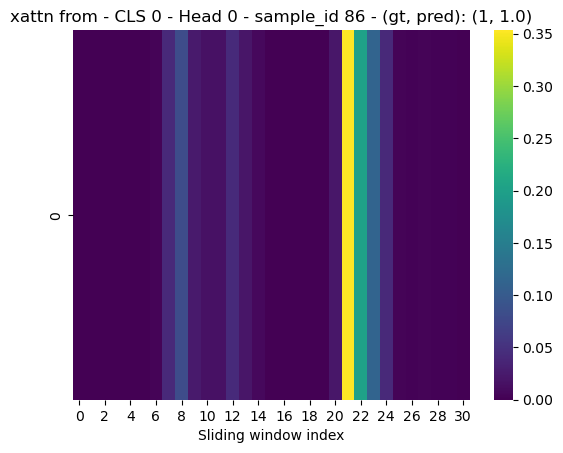

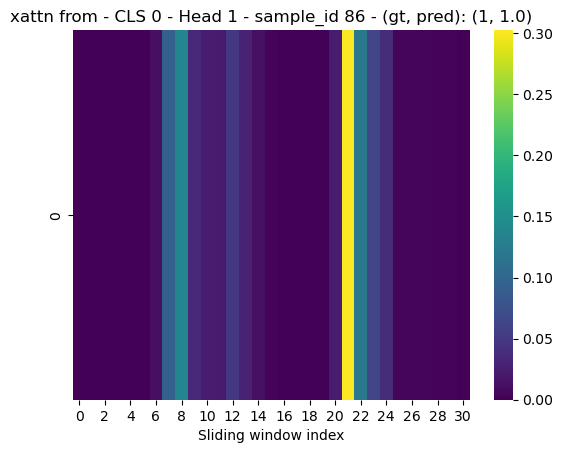

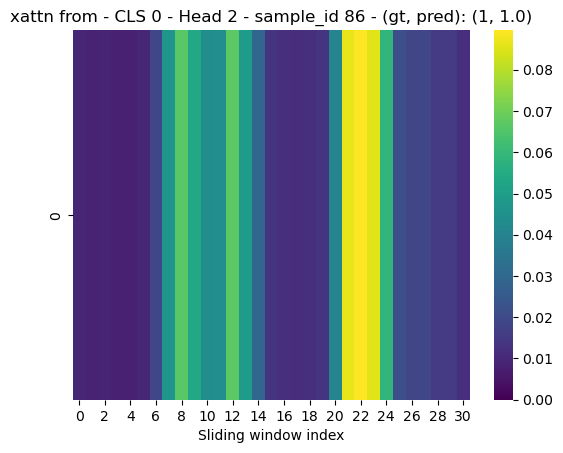

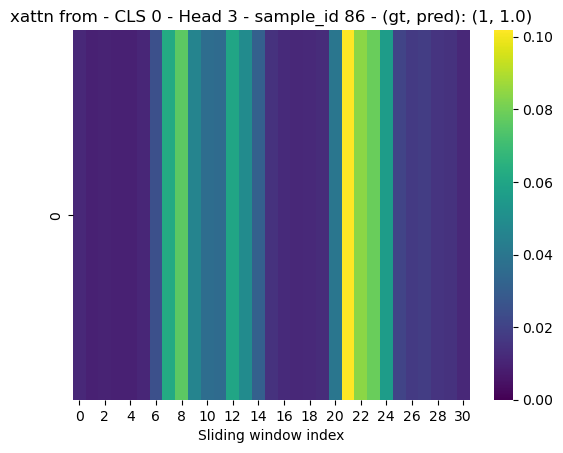

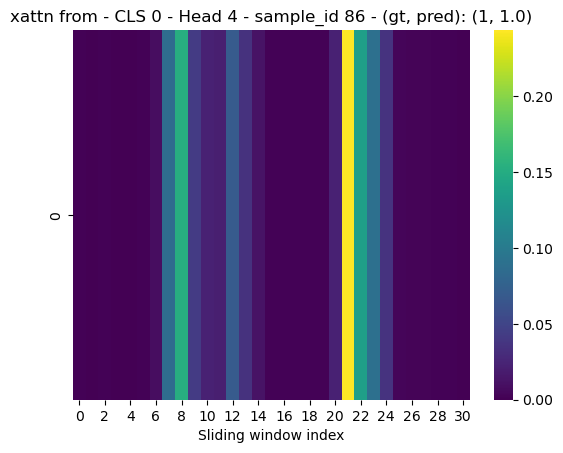

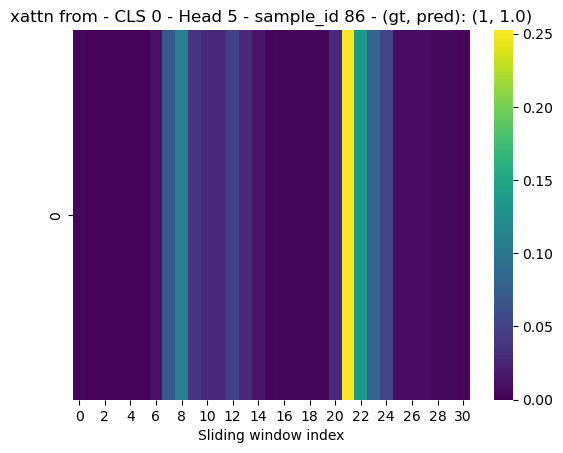

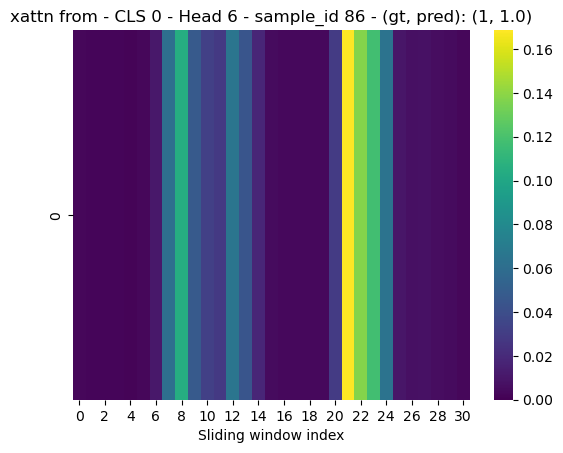

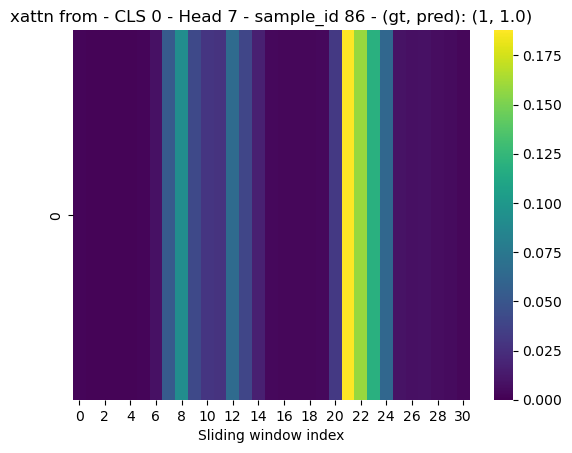

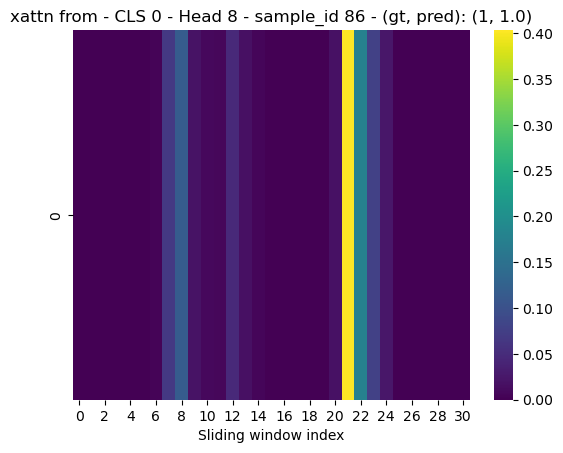

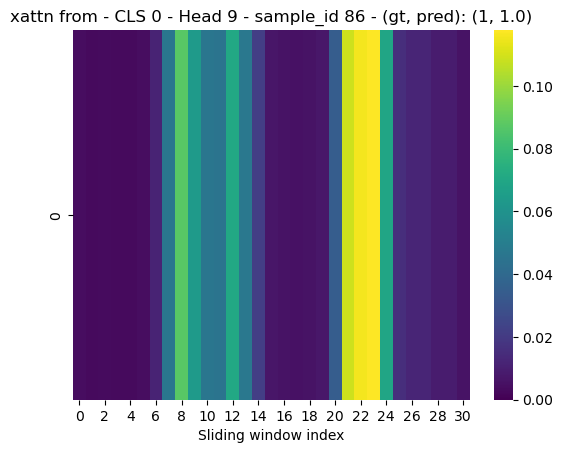

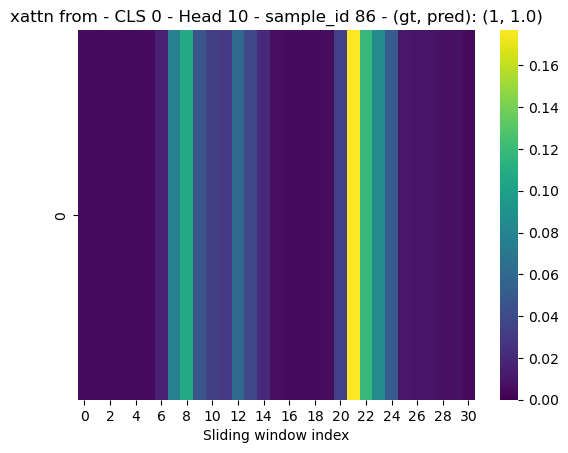

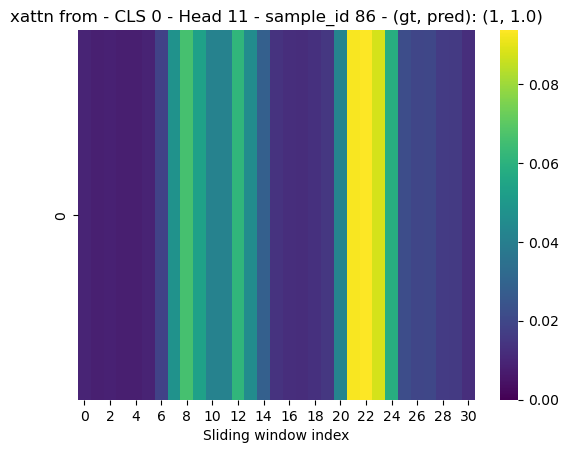

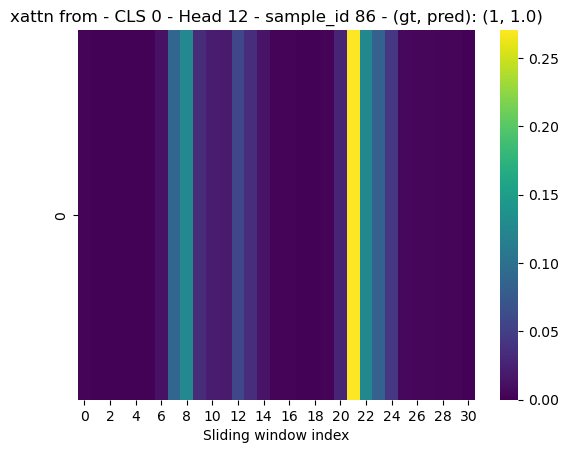

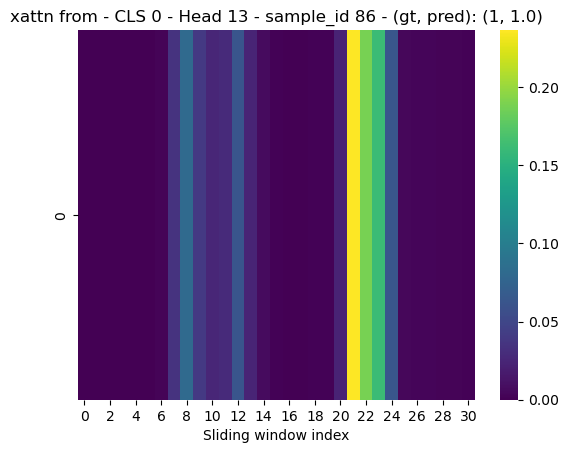

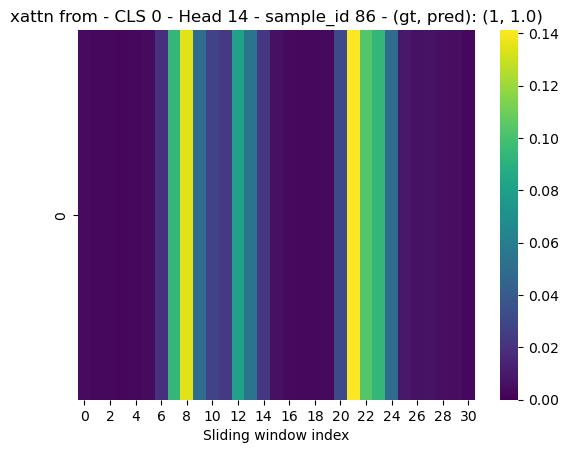

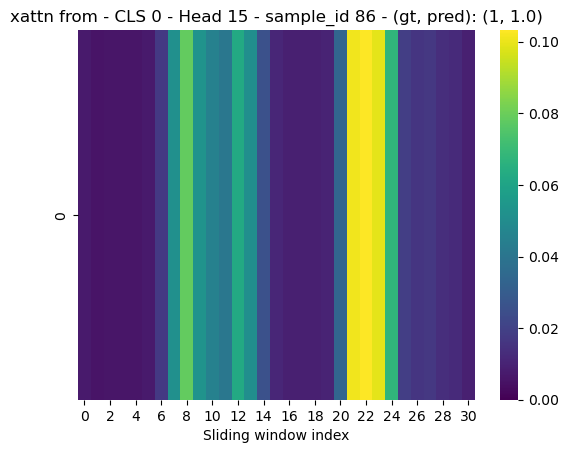

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(list_sample_id,xattn, head_id, sample_id, df,prediction):
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  mask_video_id = (list_sample_id == sample_id)
  if mask_video_id.sum() == 0:
    print(f"Sample id {sample_id} not found in xattn")
    return None
  cross_attention = xattn[mask_video_id].squeeze(0) # [sample_id=1, num_heads, CLS, nr_sliding_windows]
  if head_id > cross_attention.shape[0]:
    print(f"Head id {head_id} not found in xattn")
    return None
  # xattn_vecs = cross_attention.squeeze(1)
  for idx_cls_head in range(cross_attention.shape[1]): 
    sns.heatmap(cross_attention[head_id][idx_cls_head][None, :], cmap='viridis', cbar=True,vmin=0)
    plt.xlabel("Sliding window index")
    plt.title(f"xattn from - CLS {idx_cls_head} - Head {head_id} - sample_id {sample_id} - (gt, pred): ({gt}, {prediction})")
    plt.show()

sample_id = 86
for head_id in range(test_xattn.shape[1]):
  plot_attention_map(list_sample_id=test_list_sample_id,
                    xattn=test_xattn,
                    head_id=head_id,
                    df=df,
                    sample_id=sample_id,
                    prediction=test_history_predictions[sample_id].item())

In [2]:
import custom.tools as tools

feat_path ="partA/video/features/all_front_giantFinetuned_1_1_1_.safetensors"
dict_data = tools.load_dict_data(feat_path)
print(dict_data['features'].shape)

/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/update_torch_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:462: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/ho

torch.Size([269576, 1, 1, 1, 1408])


In [15]:
import torch
ordered_tensor = torch.arange(0, 20).reshape(2,2, 5)
ordered_tensor.reshape(-1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [5]:
import numpy as np
nr_samples = 1
pca_nr_batch = 4
np.array_split(np.arange(nr_samples), pca_nr_batch)

[array([0]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)]

In [9]:
import custom.tools as tools
import numpy as np
import pandas as pd
import os

path_data = "partA/video/features/all_front_giant_finetuned_1_1_1_stride4_interp_mirror.safetensors"
dict_data = tools.load_dict_data(path_data)
idx = 4264
mask = dict_data['list_sample_id'] == idx
idx_feats = dict_data['features'][mask]
idx_feats.shape

torch.Size([33, 1, 1, 1, 1408])

In [2]:
import os
import shutil

def link_all_pngs(root_folder, link_folder_name="linked_pngs"):
    # Create the destination folder
    link_folder = os.path.join(root_folder, link_folder_name)
    os.makedirs(link_folder, exist_ok=True)

    # Walk through the root directory and its subdirectories
    count = 0
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(".png"):
                src_path = os.path.join(dirpath, filename)
                # Create a unique name in the link folder to avoid collisions
                rel_path = os.path.relpath(src_path, root_folder)
                safe_name = rel_path.replace(os.sep, "__")
                dest_path = os.path.join(link_folder, safe_name)

                try:
                    os.symlink(src_path, dest_path)
                    count += 1
                except FileExistsError:
                    print(f"Link already exists: {dest_path}")
                except OSError:
                    # On Windows without admin privileges, use copy instead of symlink
                    shutil.copy2(src_path, dest_path)
                    count += 1

    print(f"{count} PNG files linked/copied to: {link_folder}")

# Example usage:
link_all_pngs("/media/villi/TOSHIBA EXT/test_video/test_May_30_tsne/tsne_feats/whole_frontalized_giant_mirror_interpolation")


580 PNG files linked/copied to: /media/villi/TOSHIBA EXT/test_video/test_May_30_tsne/tsne_feats/whole_frontalized_giant_mirror_interpolation/linked_pngs


In [2]:
import cv2

def draw_grid(frame, grid_size):
    rows, cols = grid_size
    h, w, _ = frame.shape

    # Compute spacing
    row_step = h // rows
    col_step = w // cols

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * row_step
        cv2.line(frame, (0, y), (w, y), color=(0, 255, 0), thickness=1)

    # Draw vertical lines
    for j in range(1, cols):
        x = j * col_step
        cv2.line(frame, (x, 0), (x, h), color=(0, 255, 0), thickness=1)

    return frame

def overlay_grid_on_video(video_path, grid_size, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Codec for .mp4 files

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_with_grid = draw_grid(frame, grid_size)
        out.write(frame_with_grid)

    cap.release()
    out.release()
    print(f"Output video saved to {output_path}")

# Example usage
video_path = "/media/villi/TOSHIBA EXT/video_frontalized_interpolated_mirror/071313_m_41/071313_m_41-BL1-081.mp4"
output_path = "output_video_with_grid.mp4"
grid_size = (16, 16)  # 4x4 grid
overlay_grid_on_video(video_path, grid_size, output_path)


Output video saved to output_video_with_grid.mp4


In [11]:
import torch

tensor = torch.randn(1, 2, 5)  # shape (1, 8, 16, 16, 2)
tensor[3:] = 99999
tensor

tensor([[[-0.8931,  1.2523, -1.7455, -1.2628, -0.0685],
         [-1.0561,  1.4669,  1.5593, -0.0422, -0.4330]]])

Figure size in inches: (3.0, 3.0)


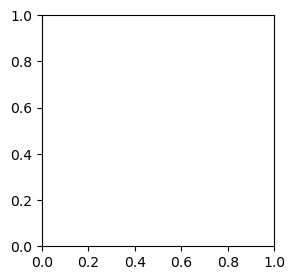

In [14]:
import matplotlib.pyplot as plt

# Desired size in pixels
width_px = 300
height_px = 300
dpi = 100  # dots per inch

# Convert pixels to inches
figsize = (width_px / dpi, height_px / dpi)
print(f"Figure size in inches: {figsize}")
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)


# MISS PREDICTIONS

In [8]:
import pandas as pd
import pickle
import os
import custom.tools as tools

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_May_23/NP_vs_PA4/finetuned_1_1_1_stride4_ce/history_run_samples_0_4_finetuned_ce_1_1_1_stride4_2489476_ATTENTIVE_JEPA_harlock_1747827509/1747827511889_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
key = "k0_cross_val_sub_0"
df_csv_path = os.path.dirname(pkl_path)
csv_file = [f for f in os.listdir(df_csv_path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(df_csv_path,csv_file),sep='\t')
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
best_epoch = data['results'][key]['train_val']['best_model_idx']
num_epochs = len(data['results'][key]['train_val']['train_losses'])
train_history_pred = data['results'][key]['train_val']['history_train_sample_predictions']
val_history_pred = data['results'][key]['train_val']['history_val_sample_predictions']
top_k = 20
miss_predictions_train_label,miss_predictions_train_sbj = tools.count_mispredictions(train_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_val_label,miss_predictions_val_sbj = tools.count_mispredictions(val_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_train_sbj_best_epoch = {k:v[best_epoch] for k,v in train_history_pred.items()}
miss_predictions_val_sbj_best_epoch = {k:v[best_epoch] for k,v in val_history_pred.items()}
test_history_pred = data['results'][key]['test']['history_test_sample_predictions']
_,miss_predictions_train_sbj_best = tools.count_mispredictions(miss_predictions_train_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_val_sbj_best = tools.count_mispredictions(miss_predictions_val_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_test_sbj_best = tools.count_mispredictions(test_history_pred,df,top_k=top_k,return_miss_per_subject=True)


In [25]:
history_pred = miss_predictions_train_sbj_best_epoch
miss_prediction_sbj_sample_value = {}
for sample_id,pred_history in history_pred.items():
  # Get the ground truth class ID for the sample ID and count the number of mispredictions
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  sbj = df[df['sample_id'] == sample_id]['subject_id'].values[0]
  if pred_history != gt:
    if sbj not in miss_prediction_sbj_sample_value:
      miss_prediction_sbj_sample_value[sbj] = {}
    miss_prediction_sbj_sample_value[sbj][sample_id] = {'gt': gt, 'pred': pred_history.item(),'name':df[df['sample_id'] == sample_id]['sample_name'].values[0]}

In [26]:
miss_prediction_sbj_sample_value[76]

{7501: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-081'},
 7502: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-082'},
 7503: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-083'},
 7505: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-085'},
 7506: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-086'},
 7511: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-091'},
 7513: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-093'},
 7518: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-098'},
 7519: {'gt': 0, 'pred': 1, 'name': '111609_m_65-BL1-099'},
 7582: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-008'},
 7583: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-014'},
 7584: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-015'},
 7585: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-022'},
 7586: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-023'},
 7587: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-028'},
 7588: {'gt': 1, 'pred': 0, 'name': '111609_m_65-PA4-030'},
 7589: {'gt': 1, 'pred': 0, 'name': '111

# TEST Accuracy

In [ ]:
import torch
import numpy as np
import custom.tools as tools 
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
)


# Test case 1: Simple multi-class classification
true_labels_1 = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels_1 = np.array([0, 1, 2, 0, 2, 1, 0, 1, 2])
num_classes_1 = 3
cm_torch_1 = torch.tensor(confusion_matrix(true_labels_1, predicted_labels_1))
results_1 = tools.evaluate_classification_from_confusion_matrix(cm_torch_1)

print("Test Case 1:")
print("Confusion Matrix:\n", cm_torch_1)

sklearn_precision_1 = precision_score(true_labels_1, predicted_labels_1, average=None)
sklearn_recall_1 = recall_score(true_labels_1, predicted_labels_1, average=None)
sklearn_accuracy_1 = accuracy_score(true_labels_1, predicted_labels_1)
sklearn_macro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_macro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_micro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_micro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_weighted_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='weighted')
sklearn_weighted_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='weighted')

print("Your Results:")
for key, value in results_1.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_1}")
print(f"recall_per_class: {sklearn_recall_1}")
print(f"macro_precision: {sklearn_macro_precision_1}")
print(f"macro_recall: {sklearn_macro_recall_1}")
print(f"micro_precision: {sklearn_micro_precision_1}")
print(f"micro_recall: {sklearn_micro_recall_1}")
print(f"weighted_precision: {sklearn_weighted_precision_1}")
print(f"weighted_recall: {sklearn_weighted_recall_1}")
print(f"accuracy: {sklearn_accuracy_1}")

# Comparison for Test Case 1
print("\nComparison with Scikit-learn (Test Case 1):")
np.testing.assert_allclose(results_1['precision_per_class'], sklearn_precision_1, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_1['recall_per_class'], sklearn_recall_1, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_1['macro_precision'], sklearn_macro_precision_1, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_1['macro_recall'], sklearn_macro_recall_1, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_1['micro_precision'], sklearn_micro_precision_1, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_1['micro_recall'], sklearn_micro_recall_1, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_1['weighted_precision'], sklearn_weighted_precision_1, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_1['weighted_recall'], sklearn_weighted_recall_1, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_1['accuracy'], sklearn_accuracy_1, err_msg="Accuracy mismatch")
print("All values in Test Case 1 match scikit-learn.")

print("-" * 50)

# Test case 2: Binary classification
true_labels_2 = np.array([0, 0, 1, 1, 1])
predicted_labels_2 = np.array([0, 1, 1, 0, 1])
num_classes_2 = 2
cm_torch_2 = torch.tensor(confusion_matrix(true_labels_2, predicted_labels_2))
results_2 = tools.evaluate_classification_from_confusion_matrix(cm_torch_2)

print("\nTest Case 2 (Binary Classification):")
print("Confusion Matrix:\n", cm_torch_2)

sklearn_precision_2 = precision_score(true_labels_2, predicted_labels_2, average=None)
sklearn_recall_2 = recall_score(true_labels_2, predicted_labels_2, average=None)
sklearn_accuracy_2 = accuracy_score(true_labels_2, predicted_labels_2)
sklearn_macro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_macro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_micro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_micro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_weighted_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='weighted')
sklearn_weighted_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='weighted')

print("Your Results:")
for key, value in results_2.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_2}")
print(f"recall_per_class: {sklearn_recall_2}")
print(f"macro_precision: {sklearn_macro_precision_2}")
print(f"macro_recall: {sklearn_macro_recall_2}")
print(f"micro_precision: {sklearn_micro_precision_2}")
print(f"micro_recall: {sklearn_micro_recall_2}")
print(f"weighted_precision: {sklearn_weighted_precision_2}")
print(f"weighted_recall: {sklearn_weighted_recall_2}")
print(f"accuracy: {sklearn_accuracy_2}")

# Comparison for Test Case 2
print("\nComparison with Scikit-learn (Test Case 2):")
np.testing.assert_allclose(results_2['precision_per_class'], sklearn_precision_2, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_2['recall_per_class'], sklearn_recall_2, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_2['macro_precision'], sklearn_macro_precision_2, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_2['macro_recall'], sklearn_macro_recall_2, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_2['micro_precision'], sklearn_micro_precision_2, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_2['micro_recall'], sklearn_micro_recall_2, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_2['weighted_precision'], sklearn_weighted_precision_2, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_2['weighted_recall'], sklearn_weighted_recall_2, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_2['accuracy'], sklearn_accuracy_2, err_msg="Accuracy mismatch")
print("All values in Test Case 2 match scikit-learn.")

print("-" * 50)

# Test case 3: Imbalanced dataset
true_labels_3 = np.array([0, 0, 0, 0, 1, 1])
predicted_labels_3 = np.array([0, 0, 1, 0, 1, 0])
num_classes_3 = 2
cm_torch_3 = torch.tensor(confusion_matrix(true_labels_3, predicted_labels_3))
results_3 = tools.evaluate_classification_from_confusion_matrix(cm_torch_3)

print("\nTest Case 3 (Imbalanced Dataset):")
print("Confusion Matrix:\n", cm_torch_3)

sklearn_precision_3 = precision_score(true_labels_3, predicted_labels_3, average=None)
sklearn_recall_3 = recall_score(true_labels_3, predicted_labels_3, average=None)
sklearn_accuracy_3 = accuracy_score(true_labels_3, predicted_labels_3)
sklearn_macro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_macro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_micro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_micro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_weighted_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='weighted')
sklearn_weighted_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='weighted')

print("Your Results:")
for key, value in results_3.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_3}")
print(f"recall_per_class: {sklearn_recall_3}")
print(f"macro_precision: {sklearn_macro_precision_3}")
print(f"macro_recall: {sklearn_macro_recall_3}")
print(f"micro_precision: {sklearn_micro_precision_3}")
print(f"micro_recall: {sklearn_micro_recall_3}")
print(f"weighted_precision: {sklearn_weighted_precision_3}")
print(f"weighted_recall: {sklearn_weighted_recall_3}")
print(f"accuracy: {sklearn_accuracy_3}")

# Comparison for Test Case 3
print("\nComparison with Scikit-learn (Test Case 3):")
np.testing.assert_allclose(results_3['precision_per_class'], sklearn_precision_3, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_3['recall_per_class'], sklearn_recall_3, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_3['macro_precision'], sklearn_macro_precision_3, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_3['macro_recall'], sklearn_macro_recall_3, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_3['micro_precision'], sklearn_micro_precision_3, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_3['micro_recall'], sklearn_micro_recall_3, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_3['weighted_precision'], sklearn_weighted_precision_3, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_3['weighted_recall'], sklearn_weighted_recall_3, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_3['accuracy'], sklearn_accuracy_3, err_msg="Accuracy mismatch")
print("All values in Test Case 3 match scikit-learn.")

Test Case 1:
Confusion Matrix:
 tensor([[3, 0, 0],
        [0, 2, 1],
        [0, 1, 2]])
Your Results:
precision_per_class: [1.        0.6666667 0.6666667]
recall_per_class: [1.        0.6666667 0.6666667]
macro_precision: 0.7777778506278992
macro_recall: 0.7777778506278992
micro_precision: 0.7777777910232544
micro_recall: 0.7777777910232544
weighted_precision: 0.7777777910232544
weighted_recall: 0.7777777910232544
accuracy: 0.7777777910232544

Scikit-learn Results:
precision_per_class: [1.         0.66666667 0.66666667]
recall_per_class: [1.         0.66666667 0.66666667]
macro_precision: 0.7777777777777777
macro_recall: 0.7777777777777777
micro_precision: 0.7777777777777778
micro_recall: 0.7777777777777778
weighted_precision: 0.7777777777777778
weighted_recall: 0.7777777777777778
accuracy: 0.7777777777777778

Comparison with Scikit-learn (Test Case 1):
All values in Test Case 1 match scikit-learn.
--------------------------------------------------

Test Case 2 (Binary Classification